In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import selfies as sf
import mutations as mut
from functools import partial
import metrics as met
import functions as fn
from constants import *
from rdkit import Chem
from rdkit.Chem import Draw
import seaborn as sns
import pandas as pd
from datetime import datetime
import time
from tqdm import tqdm
from guacamol import standard_benchmarks
import numpy as np
import random
from copy import copy
import crossovers as xo
import seaborn as sns
import matplotlib.pyplot as plt
import os

c:\Users\marti\anaconda3\envs\thesis_3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED_SIZE_LIST = [10, 100, 1000, 10000, 100000]
SEED_SIZE = SEED_SIZE_LIST[2]
SEED_LIST = [0,1,2]
SEED = SEED_LIST[2]
BUDGET_LIST = [100, 1000, 10000, 100000]
BUDGET = BUDGET_LIST[2]
GENERATIONS = 50




SAVE = True

In [4]:
celecoxib = 'O=S(=O)(c3ccc(n1nc(cc1c2ccc(cc2)C)C(F)(F)F)cc3)N'
troglitazone = 'O=C1NC(=O)SC1Cc4ccc(OCC3(Oc2c(c(c(O)c(c2CC3)C)C)C)C)cc4'
task_f = [partial(met.compound_similarity,target_smile = celecoxib),
         partial(met.compound_similarity,target_smile = troglitazone),
         partial(standard_benchmarks.median_camphor_menthol().objective.score_list),
         partial(standard_benchmarks.median_tadalafil_sildenafil().objective.score_list),
         partial(standard_benchmarks.hard_osimertinib().objective.score_list),
         partial(standard_benchmarks.zaleplon_with_other_formula().objective.score_list)]
task_names = ['celecoxib','troglitazone','med1','med2','osimertinib','zaleplon']




# Single metric optimization

In [5]:
#f = standard_benchmarks.zaleplon_with_other_formula().objective.score_list()

metric_function_list = [
    #partial(standard_benchmarks.zaleplon_with_other_formula().objective.score_list)
    #partial(standard_benchmarks.median_tadalafil_sildenafil().objective.score_list)
    partial(met.compound_similarity,target_smile = troglitazone)
]
metrics = ['Metric 1']

In [6]:
mutation_function_list = [
    partial(mut.replacement,n=1 ,ring_aware= False)
    ,partial(mut.addition,fragment_size=1,rings=False, branches=False)
    ,partial(mut.deletion,n=1)
]

In [7]:
for task_i in range(len(task_names[:2])):
    task_i+=2
    curr_task_f = task_f[task_i]
    curr_task_name = task_names[task_i]
    metric_function_list = [curr_task_f]

    current_dateTime = datetime.now()
    time_format = f"{current_dateTime.date()}_{str(current_dateTime.hour).zfill(2)}-{str(current_dateTime.minute).zfill(2)}-{str(current_dateTime.second).zfill(2)}"
    chem_lookup = {}

    try:
        pbar.close()
        print("Ignore the previous status bar. It is from the previous run.")
    except:
        pass


    for SEED in SEED_LIST:#SEED_LIST[1:]:
        for SEED_SIZE in SEED_SIZE_LIST[1:]:#[SEED_SIZE_LIST[1]]:#
            #SEED_PATH = f"../data/seed_{SEED}/rand_{SEED_SIZE}.tsv"
            #seed_df = pd.read_table(SEED_PATH) 
            #initial_pop, _, chem_lookup = fn.seeds_to_pop(seed_df,metric_function_list)
            INITIAL_PATH = f"{curr_task_name}_{SEED}_{SEED_SIZE}.csv"
            initial_pop = pd.read_csv(INITIAL_PATH)
            chem_lookup = fn.dataframe_to_dict(initial_pop)

            #chem_lookup.update(initial_pop.set_index('SMILES molecule')['Metric 1'].to_dict()) #canon and set
            for BUDGET in [BUDGET_LIST[-1]]:#BUDGET_LIST[:4]:#BUDGET_LIST[:4]#
                setup_name = f"seed_{SEED}_rand_{SEED_SIZE}"
                file_name = f"{time_format}_{setup_name}_budget_{BUDGET}"
                B0 = copy(BUDGET)
                generation = 0
                t0 = time.time()
                
                first_generation_fraction = 0.05 #hyperparam
                N = int(BUDGET * first_generation_fraction) #1st generation size

                if len(initial_pop)>=N:
                    initial_best = initial_pop.head(N)
                else:
                    initial_best = initial_pop
                gen_history = pd.DataFrame(initial_pop)
                gen_best_history = pd.DataFrame(initial_best)
                temp_best = initial_best.copy(deep=True)
                cost_history = []

                #rest of hyperparams
                crossover = True
                crossover_ratio = 0.2

                decreasing_size = True #if True, (leftover) BUDGET * next_generation_fraction = new N, else B0 * nfg = N
                next_generation_fraction = 0.05 #size of next generation

                minimal_next_generation_fraction = 0.0025
                max_gens = 500

                canonical_best = False
                percent_best_fraction = 0.1

                include_initial_pop = False
                initial_sample_fraction = 0.5 #initial_sample_size = len(temp_best) *  initial_sample_fraction ))

                diversity_decay = True
                selection_exponenet = 1


                pbar = tqdm(desc=f"Working with budget of {B0}",
                            total=B0)
                while (BUDGET > len(temp_best)):
                    diversity = fn.get_last_diversity(temp_best)
                    homogenity = 1 - diversity
                    temp_pop, cost, chem_lookup = fn.populate_from_df(temp_best,N,metric_function_list,mutation_function_list,
                                                generation+1,include_seeds=True,fitness='Fitness',crossover=crossover, crossover_type=0,
                                                crossover_ratio=crossover_ratio, proportional_sampling = True, 
                                                lookup_dict=copy(chem_lookup), randomize_seeds=True,
                                                avg_dist=diversity_decay,
                                                exp=selection_exponenet)
                    cost_history.append(cost)
                    BUDGET -= cost
                    temp_pop.reset_index(drop=True,inplace=True)
                    gen_history = pd.concat([gen_history,temp_pop])
                    gen_history.reset_index(drop=True,inplace=True)

                    if canonical_best:
                        temp_best = fn.get_canonical_percent_best(temp_pop,['Fitness'],percent_best_fraction,minimize=False)
                    else:
                        temp_best = fn.get_percent_best(temp_pop,['Fitness'],percent_best_fraction,minimize=False)    
                    gen_best_history = pd.concat([gen_best_history,temp_best])
                    gen_best_history.reset_index(drop=True,inplace=True)
                    
                    
                    
                    if include_initial_pop:
                        initial_sample_size = int(np.ceil(  len(temp_best) *  initial_sample_fraction   ))
                        temp_best = pd.concat([temp_best, initial_pop.sample(initial_sample_size)])
                    
                    if decreasing_size:
                        N = int(np.ceil(BUDGET * next_generation_fraction))
                    else:
                        N = int(np.ceil(B0 * next_generation_fraction))
                    if N<=int(np.ceil(minimal_next_generation_fraction*B0)):
                        N =int(np.ceil(minimal_next_generation_fraction*B0))
                    pbar.update(cost)
                    generation += 1

                    if generation>=max_gens:
                        break
                pbar.update(BUDGET)
                pbar.close()



                Z = 8
                #Z0 = 
                """
                crossover = True
                crossover_ratio = 0.2

                decreasing_size = True #if True, (leftover) BUDGET * next_generation_fraction = new N, else B0 * nfg = N
                next_generation_fraction = 0.05 #size of next generation

                minimal_next_generation_fraction = 0.0025
                max_gens = 500

                canonical_best = False
                percent_best_fraction = 0.1

                include_initial_pop = False
                initial_sample_fraction = 0.5 #initial_sample_size = len(temp_best) *  initial_sample_fraction ))

                diversity_decay = True
                selection_exponenet = 1
                """
                # Z1 = 
                # same as Z0, but with selection_exponenet ==2
                # Z2 =
                # same as Z0, but with canonical best == True
                # Z3 = 
                # same as Z2, but with include_initial_pop == True
                # Z4 =
                # same as Z3, but with initial_sample_fraction == 2.0
                # Z5 =
                # same as Z0
                # Z6
                # same as Z0, but with diversity_decay == False
                # Z7
                # same as Z6
                # Z8
                # same as Z0   




                print(f"Done {generation} in {time.time()-t0}")
                FOLDER_P = f"best_{curr_task_name}"
                if SAVE:
                    if not os.path.exists(FOLDER_P):
                        os.makedirs(FOLDER_P)
                    gen_best_history.to_csv(f"{FOLDER_P}/{file_name}.csv")
                FOLDER_P = f"all_{curr_task_name}"
                if SAVE:
                    if not os.path.exists(FOLDER_P):
                        os.makedirs(FOLDER_P)
                    gen_history.to_csv(f"{FOLDER_P}/{file_name}.csv")

    ###
    latest_gen = gen_best_history[gen_best_history['Generation']==gen_best_history['Generation'].max()]
    latest_gen.head()

Working with budget of 100: 100%|██████████| 100/100 [00:00<00:00, 110.99it/s]


Done 61 in 0.9030008316040039


Working with budget of 1000: 100%|██████████| 1000/1000 [00:04<00:00, 204.91it/s]


Done 175 in 4.883185625076294


Working with budget of 10000: 100%|██████████| 10000/10000 [00:55<00:00, 178.99it/s]


Done 339 in 55.87207651138306


Working with budget of 100: 100%|██████████| 100/100 [00:00<00:00, 135.87it/s]


Done 63 in 0.7540044784545898


Working with budget of 1000: 100%|██████████| 1000/1000 [00:04<00:00, 243.78it/s]


Done 177 in 4.105044603347778


Working with budget of 10000: 100%|██████████| 10000/10000 [00:54<00:00, 182.14it/s]


Done 294 in 54.90884828567505


Working with budget of 100: 100%|██████████| 100/100 [00:00<00:00, 126.59it/s]


Done 64 in 0.8120975494384766


Working with budget of 1000: 100%|██████████| 1000/1000 [00:04<00:00, 233.81it/s]


Done 126 in 4.280012369155884


Working with budget of 10000: 100%|██████████| 10000/10000 [00:59<00:00, 168.32it/s]


Done 325 in 59.41503930091858


Working with budget of 100: 100%|██████████| 100/100 [00:02<00:00, 43.20it/s]


Done 73 in 2.348783016204834


Working with budget of 1000: 100%|██████████| 1000/1000 [00:09<00:00, 102.10it/s]


Done 198 in 9.803502559661865


Working with budget of 10000: 100%|██████████| 10000/10000 [01:50<00:00, 90.24it/s]


Done 500 in 110.82741522789001


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 97.26it/s]


Done 63 in 1.2241415977478027


Working with budget of 1000: 100%|██████████| 1000/1000 [00:05<00:00, 196.12it/s]


Done 119 in 5.102969646453857


Working with budget of 10000: 100%|██████████| 10000/10000 [01:14<00:00, 134.97it/s]


Done 487 in 74.09485745429993


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 67.37it/s]


Done 66 in 1.5260727405548096


Working with budget of 1000: 100%|██████████| 1000/1000 [00:05<00:00, 181.96it/s]


Done 117 in 5.498717546463013


Working with budget of 10000: 100%|██████████| 10000/10000 [00:53<00:00, 187.20it/s]


Done 201 in 53.42570948600769


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 88.20it/s]


Done 66 in 1.1508920192718506


Working with budget of 1000: 100%|██████████| 1000/1000 [00:05<00:00, 197.70it/s]


Done 131 in 5.060245037078857


Working with budget of 10000: 100%|██████████| 10000/10000 [01:22<00:00, 121.83it/s]


Done 500 in 82.0882019996643


Working with budget of 100: 100%|██████████| 100/100 [00:02<00:00, 39.32it/s]


Done 66 in 2.5855205059051514


Working with budget of 1000: 100%|██████████| 1000/1000 [00:08<00:00, 124.98it/s]


Done 122 in 8.013264179229736


Working with budget of 10000: 100%|██████████| 10000/10000 [01:28<00:00, 112.84it/s]


Done 482 in 88.63549399375916


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 73.96it/s]


Done 67 in 1.5430161952972412


Working with budget of 1000: 100%|██████████| 1000/1000 [00:05<00:00, 188.41it/s]


Done 123 in 5.310537338256836


Working with budget of 10000: 100%|██████████| 10000/10000 [00:54<00:00, 182.59it/s]


Done 238 in 54.77270317077637


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 80.58it/s]


Done 63 in 1.2590038776397705


Working with budget of 1000: 100%|██████████| 1000/1000 [00:05<00:00, 174.85it/s]


Done 167 in 5.721324443817139


Working with budget of 10000: 100%|██████████| 10000/10000 [01:00<00:00, 166.23it/s]


Done 346 in 60.16438317298889


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 70.21it/s]


Done 65 in 1.44523024559021


Working with budget of 1000: 100%|██████████| 1000/1000 [00:08<00:00, 115.87it/s]


Done 273 in 8.633562326431274


Working with budget of 10000: 100%|██████████| 10000/10000 [01:27<00:00, 114.31it/s]


Done 500 in 87.48445463180542


Working with budget of 100: 100%|██████████| 100/100 [00:02<00:00, 35.14it/s]


Done 73 in 2.891721487045288


Working with budget of 1000: 100%|██████████| 1000/1000 [00:10<00:00, 96.23it/s]


Done 192 in 10.4024019241333


Working with budget of 10000: 100%|██████████| 10000/10000 [01:37<00:00, 102.93it/s]


Done 500 in 97.17102241516113
Ignore the previous status bar. It is from the previous run.


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 51.48it/s]


Done 64 in 2.1553945541381836


Working with budget of 1000: 100%|██████████| 1000/1000 [00:10<00:00, 98.44it/s]


Done 113 in 10.161210298538208


Working with budget of 10000: 100%|██████████| 10000/10000 [01:05<00:00, 151.97it/s]


Done 141 in 65.80833101272583


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 57.52it/s]


Done 70 in 1.7555291652679443


Working with budget of 1000: 100%|██████████| 1000/1000 [00:07<00:00, 125.62it/s]


Done 146 in 7.9638330936431885


Working with budget of 10000: 100%|██████████| 10000/10000 [01:42<00:00, 97.64it/s]


Done 318 in 102.42460989952087


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 58.73it/s]


Done 69 in 1.732985019683838


Working with budget of 1000: 100%|██████████| 1000/1000 [00:06<00:00, 149.49it/s]


Done 127 in 6.691317319869995


Working with budget of 10000: 100%|██████████| 10000/10000 [01:05<00:00, 153.79it/s]


Done 179 in 65.02823400497437


Working with budget of 100: 100%|██████████| 100/100 [00:02<00:00, 33.87it/s]


Done 74 in 2.987208604812622


Working with budget of 1000: 100%|██████████| 1000/1000 [00:11<00:00, 90.76it/s]


Done 201 in 11.028449535369873


Working with budget of 10000: 100%|██████████| 10000/10000 [01:58<00:00, 84.71it/s]


Done 500 in 118.06059980392456


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 63.13it/s]


Done 65 in 1.7906107902526855


Working with budget of 1000: 100%|██████████| 1000/1000 [00:06<00:00, 151.57it/s]


Done 121 in 6.599809885025024


Working with budget of 10000: 100%|██████████| 10000/10000 [01:14<00:00, 134.94it/s]


Done 155 in 74.11279153823853


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 55.00it/s]


Done 67 in 1.8363089561462402


Working with budget of 1000: 100%|██████████| 1000/1000 [00:07<00:00, 125.30it/s]


Done 117 in 7.983702659606934


Working with budget of 10000: 100%|██████████| 10000/10000 [01:13<00:00, 136.76it/s]


Done 143 in 73.12248611450195


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 59.52it/s]


Done 71 in 1.7021903991699219


Working with budget of 1000: 100%|██████████| 1000/1000 [00:06<00:00, 148.39it/s]


Done 150 in 6.741919994354248


Working with budget of 10000: 100%|██████████| 10000/10000 [01:21<00:00, 122.12it/s]


Done 371 in 81.88810682296753


Working with budget of 100: 100%|██████████| 100/100 [00:02<00:00, 35.03it/s]


Done 71 in 2.8953280448913574


Working with budget of 1000: 100%|██████████| 1000/1000 [00:09<00:00, 110.97it/s]


Done 147 in 9.02150845527649


Working with budget of 10000: 100%|██████████| 10000/10000 [01:27<00:00, 114.76it/s]


Done 360 in 87.15395522117615


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 62.51it/s]


Done 63 in 1.7882730960845947


Working with budget of 1000: 100%|██████████| 1000/1000 [00:07<00:00, 140.38it/s]


Done 128 in 7.126615524291992


Working with budget of 10000: 100%|██████████| 10000/10000 [01:07<00:00, 148.53it/s]


Done 138 in 67.32993483543396


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 62.29it/s]


Done 65 in 1.6213972568511963


Working with budget of 1000: 100%|██████████| 1000/1000 [00:06<00:00, 145.89it/s]


Done 124 in 6.858644962310791


Working with budget of 10000: 100%|██████████| 10000/10000 [00:58<00:00, 171.51it/s]


Done 205 in 58.30886197090149


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 60.16it/s]


Done 64 in 1.68133544921875


Working with budget of 1000: 100%|██████████| 1000/1000 [00:07<00:00, 136.60it/s]


Done 130 in 7.324824094772339


Working with budget of 10000: 100%|██████████| 10000/10000 [01:10<00:00, 141.48it/s]


Done 196 in 70.69166302680969


Working with budget of 100: 100%|██████████| 100/100 [00:02<00:00, 36.33it/s]


Done 68 in 2.7884864807128906


Working with budget of 1000: 100%|██████████| 1000/1000 [00:08<00:00, 114.08it/s]


Done 141 in 8.776424646377563


Working with budget of 10000: 100%|██████████| 10000/10000 [01:25<00:00, 117.41it/s]


Done 359 in 85.18394184112549


In [8]:
float(latest_gen.head()['Metric 1'].max())

0.26958193300859606

In [9]:
print(len(chem_lookup))

288134


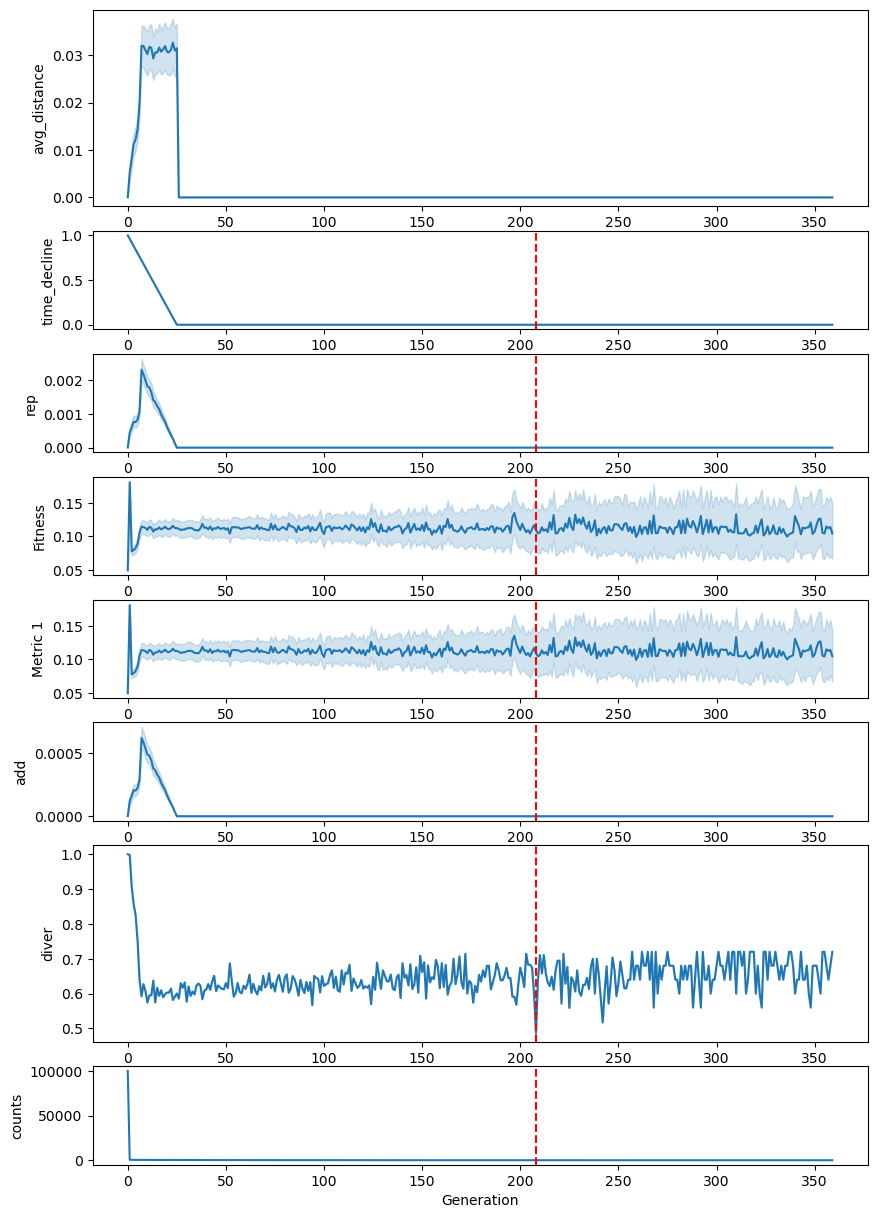

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

try:
    fig = plt.figure(figsize=(10, 15))
    gs = gridspec.GridSpec(8, 1, height_ratios=[2, 1, 1, 1, 1, 1, 2, 1])  # Adjust as needed

    # List of y-values for line plots
    y_values = ['avg_distance', 'time_decline', 'rep', 'Fitness', 'Metric 1', 'add']

    # Create subplots using the grid
    axes = [plt.subplot(gs[i]) for i in range(8)]

    # Create line plots
    for ax, y in zip(axes, y_values):
        sns.lineplot(data=gen_history, x='Generation', y=y, ax=ax)

    # Additional calculations and plots
    gen_history['diver'] = gen_history.groupby('Generation')['Canonical SMILES'].transform(lambda x: (len(pd.unique(x))-1)/len(x))
    sns.lineplot(data=gen_history, x='Generation', y='diver', ax=axes[6])

    count_data = gen_history.groupby('Generation').size().reset_index(name='counts')
    sns.lineplot(data=count_data, x='Generation', y='counts', ax=axes[7])

    # Get the generation with the lowest diversity after generation 0
    # find the row with the minimum diversity after generation 0
    min_diversity_row = gen_history[gen_history['Generation']>0].nsmallest(1, 'diver')

    # get the generation of that row
    lowest_diver = min_diversity_row['Generation'].values[0]
    #lowest_diver = gen_history[gen_history['diver']<0.2]['Generation'].min()
    # add a vertical dashed line at the generation where diversity is the lowest after generation 0
    #ax2.axvline(lowest_diver, linestyle='--', color='red')


    # Add a vertical dashed line at the first generation where diversity is the lowest after generation 0
    for ax in axes[1:]:
        ax.axvline(lowest_diver, linestyle='--', color='red')

    # Show the plot
    plt.show()

except:
    pass




Meidan score


[]

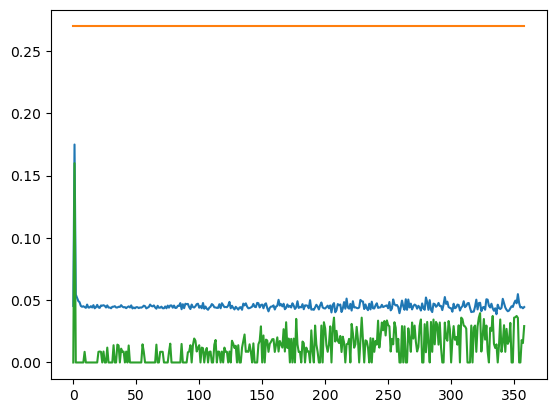

In [11]:
data = [(np.median(gen_history[gen_history['Generation']==i]['Metric 1'])) for i in range(0,np.max(gen_history['Generation']))]
sns.lineplot(data)
data = [(np.max(gen_history[gen_history['Generation']==i]['Metric 1'])) for i in range(0,np.max(gen_history['Generation']))]
sns.lineplot(data)
data = [(np.min(gen_history[gen_history['Generation']==i]['Metric 1'])) for i in range(0,np.max(gen_history['Generation']))]
sns.lineplot(data)
plt.plot()

Diversity

<Axes: >

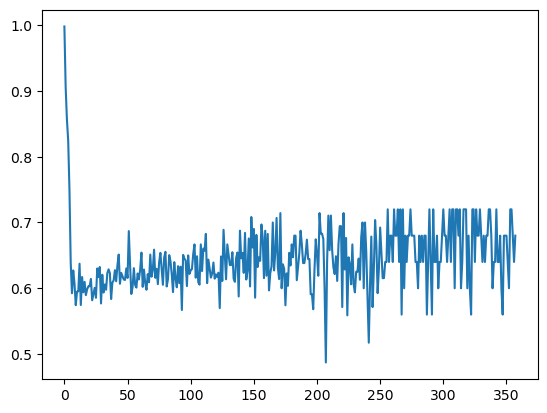

In [12]:
data = [(len(pd.unique(gen_history[gen_history['Generation']==i]['SMILES'].apply(lambda x: fn.canonicalize_smile(x))))-1)/len((gen_history[gen_history['Generation']==i]['SMILES'])) for i in range(1,gen_history['Generation'].max())]
sns.lineplot(data)

# BEST size

<Axes: >

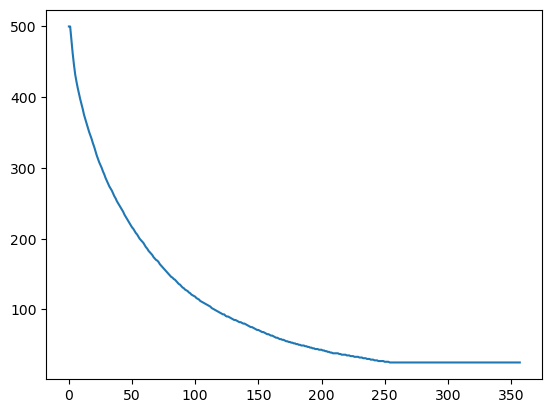

In [13]:
dayta = [len((gen_history[gen_history['Generation']==i]['SMILES'])) for i in range(1,gen_history['Generation'].max())]
sns.lineplot(dayta)

<Axes: >

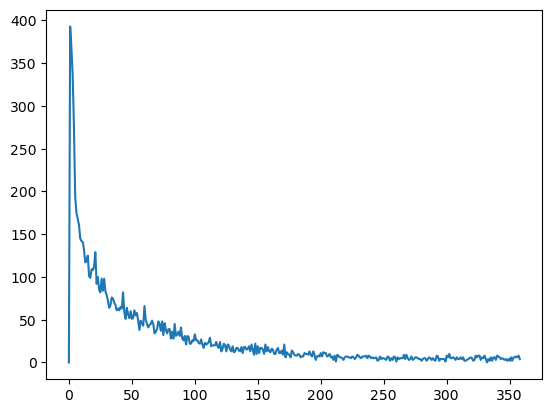

In [14]:
sns.lineplot(cost_history)

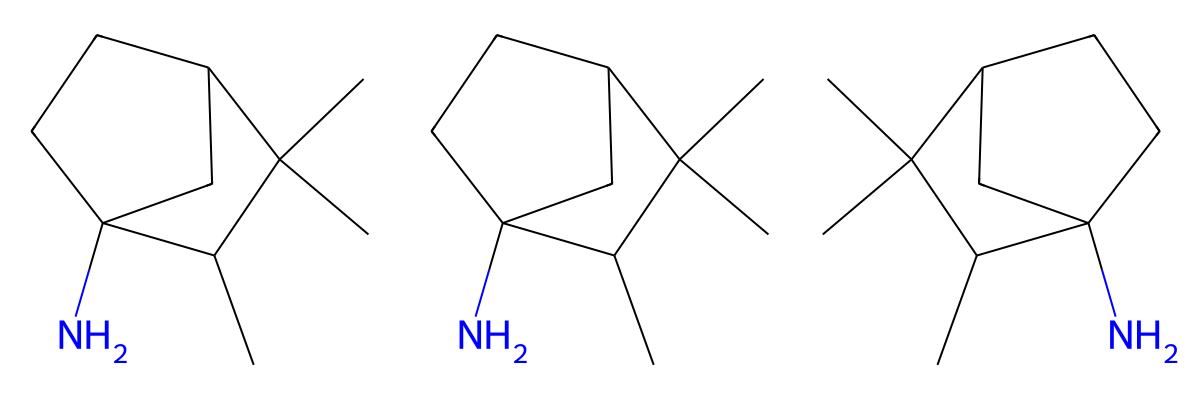

In [15]:
latest_gen_mol = [Chem.MolFromSmiles(molecule) for molecule in set(latest_gen["SMILES"][:6])]
img = Draw.MolsToGridImage(latest_gen_mol, 
                           molsPerRow=3,
                           subImgSize=(400, 400), 
                           maxMols=len(latest_gen),
                           legends=None)
display(img)

In [16]:
plot_metric_generations = False
if plot_metric_generations:
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import norm


    generations = gen_history['Generation'].unique()
    generations.sort()  # Make sure generations are sorted

    pal = sns.cubehelix_palette(len(generations), rot=-.25, light=.7)

    # Initialize a FacetGrid object
    g = sns.FacetGrid(gen_history, row="Generation", hue="Generation", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Metric 1", clip_on=False, shade=True, alpha=1, lw=1.5, bw_method=.2)
    #g.map(sns.kdeplot, "Metric 1", clip_on=False, color="w", lw=2, bw_method=.2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "Metric 1")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.0)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.xlabel('Zaleplon similarity ', fontsize=14)
    plt.ylabel('Generation', fontsize=14)

    plt.show()
